<font size=7>Eigenvectors

In this notebook will see how eigenvectors and eigenvalues are useful for data analysis. This notebook goes into more detail on an idea alluded to in section 5.13 of the class textbook, "Representing correlated inputs". A set of neurons could learn a transformation $M$ such that the internal representation $M \mathbf{x}$ is more useful than the raw input vector $\mathbf x$. We will explore what such a transformation $M$ could look like, and discuss what statistical properties of the input it is able to pick up.

Imagine an organism that lives in a flat world and perceives everything in a one-dimensional visual field. We will assume that its eyes work like a camera (i.e. not like a realistic retina), measuring light intensity at $K$ identical pixels arranged in a straight line. We will use this organism as a thought experiment to explore the statistics of input data with structure in one dimension.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Correlation and Geometric Similarity

## Correlation Matrices

If we record what our flat organism sees at $N$ different times, we will have $N$ different samples of $K$-dimensional observations.
We can collect these observations in a $K \times N$ matrix $X$ and analyze it using correlations.

We can view $X$ as a set of $N$ different $k$-variable observation vectors and take the expectation of the products of pairs of variables from these $k$ over all observations $n \in [1 \ldots N]$. This gives a normalized inner product for each pair of rows of $X$. This results in a $K \times K$ correlation matrix that represents the statistical relationships between these variables.

Alternately, we can choose to see our data as $N$ points in a $K$-dimensional space and take inner products between pairs of points. Here an inner product can be viewed as the expectation of the products of pairs of coordinate values over $k \in [1 \ldots K]$. This is an inner products of a pair of columns of $X$. This results in the $N \times N$ geometric similarity matrix, which represents geometric relationships among the points.

The geometric similarity can be useful—for example, it will have local structure if our visual observations are related to each other through time. However, the correlation matrix is more fundamental. If we get more observations of the same variables, $N$ increases but $K$ stays the same, meaning that the geometric similarity matrix grows in size and becomes unwieldy, whereas the correlation matrix just has more data available to make each individual entry more precise.

## Noise Correlations

Imagine now that the organism's eye is bombarded with random photons that have no relationship to each other. This is a completely noisy data source, where each of the data variables has mean zero and variance 1, and they are all independent.

The correlation matrix representing the relationship between the $K$ different observation dimensions is plotted below for $N=1000$ and $K=128$. There are no particular relationships between the input variables, so there is no structure to the correlation matrix. It looks like a noisy approximation to the $K \times K$ identity matrix.

In the textbook, we discussed the covariance matrix of a sample which has been normalized by subtracting its observed mean and dividing by its observed standard deviation. This results in the simple expression $\tfrac1N X X^T$ for the correlation matrix.
However, in this notebook we are going to use the numpy function `corrcoef`, which computes this matrix by first normalizing the input data for us.

The input data we are using are drawn from the standard normal distribution using the `randn` function, which means that the underlying population mean and variance are 0 and 1 respectively, but individual samples may deviate from these expectations. This means that even though you can't see it here, you have to normalize the data _even if the population statistics are already correct_.

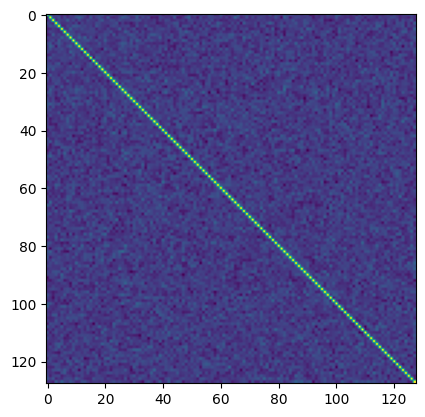

In [2]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

## Non-noise Correlations

We have seen that if all the inputs to a system are independent white noise, the correlation matrix turns out to be pretty much just the identity matrix. That means there is no way to extract a transformation that helps express the data in a more useful way. Let's compare this situation to a matrix of input data which does actually include some meaningful correlation between the input variables.

We are still working with our imaginary organism that perceives a one-dimensional visual field, but this time, the data examples that it receives are all blob-shaped stimuli at various random locations within the visual field.

These stimuli have a total width of $k = 10\text{ pixels}$, (small $k=10$ is not the same as big $K=128$) and their overall shape is a Gaussian blob with the shape parameter $\sigma = 5$. It is not terribly important which form these blobs take, as it is their spatial locality that gives the correlation matrix shown below its structure. Because our inputs are spatially localized, if at any given time $t$ we know one component $\mathbf x_t[i]$ of the observation, then we also know that $\mathbf x_t[i+1]$ is likely to have a similar value.

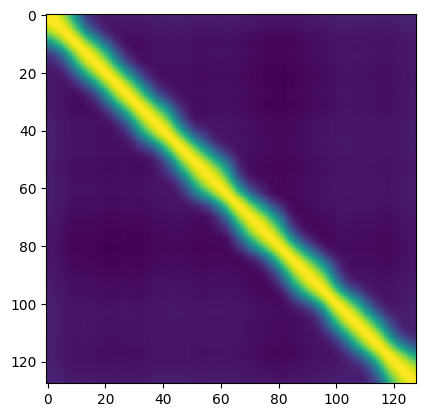

In [332]:
N, K = 250, 128
k = 10
sigma = 5

# Create raw Gaussian blobs of the given sigma. The easiest
# way to do this in numpy/scipy is to use the normal distribution
# from scipy.stats. The "points" are the points on the retina, and
# the "centers" are the centers of the different observations in
# retina space.
np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

# Mask the blobs off to k entries.
mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
# Plot the correlation.
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

# Eigenvalues and Eigenvectors

The two correlation matrices we've seen before are definitely different, but both have an overall structure that looks pretty much like just a diagonal. We can find some really interesting differences between these cases though, especially by examining the eigenvalues and eigenvectors. The set of eigenvalues of a matrix is called its “spectrum”. We will investigate this first.

## Eigenvalue Spectrum

Recall from the textbook (section 5.9) that the eigenvectors of a linear transformation $M$ are those vectors $\mathbf x$ for which there exists a scalar $\lambda$ satisfying $M \mathbf x = \lambda \mathbf x$. The scalar $\lambda$ is the eigenvalue corresponding to the eigenvector $\mathbf x$.

Here since $M = \frac1N X X^T$ is symmetric, it is also a _normal_ matrix, meaning that it commutes with its transpose. These matrices have the special property that they are always diagonalized by a unitary transformation. This in turn means that there exists an orthonormal basis $U$ which, together with the diagonal matrix $\Lambda$ whose diagonal entries are the eigenvalues of $M$, can be used to express $M$ as $U \Lambda U^T$.

All correlation matrices are Hermitian (a matrix equal to it's own conjugate transpose), so to get $U$ and $\Lambda$, we don't use the general `eig` function. Hermitian matrices have real eigenvalues (and symmetric real matrices have real eigenvectors too), but `eig` returns complex numbers. Instead, we can use `eigh` to do the whole computation in real numbers, which is a more convenient output, and even makes it a bit faster and more numerically stable too. Note that the first output of this function is not actually $\Lambda$ but rather a vector `W` of the eigenvalues in ascending order; there is usually no reason to construct the entire matrix given that it is only diagonal. If you need $\Lambda$, you can create it with `np.diag(W)`.

In [333]:
def eigenvalues_eigenvectors(A):
    W, U = np.linalg.eigh(A)
    # The rank of A can be no greater than the smaller of its
    # dimensions, so cut off the returned values there.
    rank = min(*A.shape)
    U = U[:,-rank:]
    sgn = (-1)**(U[0,:] < 0)
    # Also reverse the order of the eigenvalues because eigh()
    # returns them in ascending order but descending makes more sense.
    return W[-rank:][::-1], (U*sgn[np.newaxis,:])[:, ::-1]

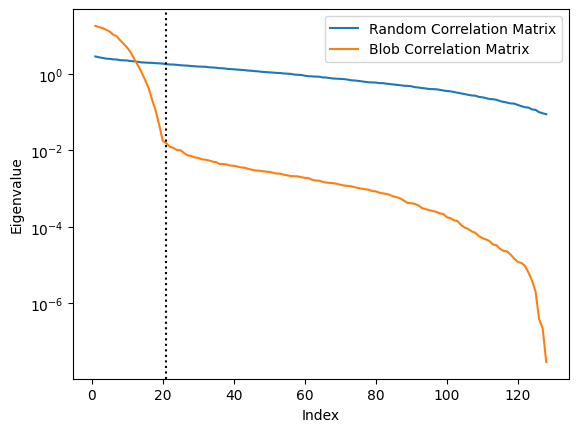

In [334]:
W_rand, U_rand = eigenvalues_eigenvectors(C_rand)  # noise correlation matrix from above
W_blob, U_blob = eigenvalues_eigenvectors(C_blob)  # non-noise correlation matrix from above 

index = 1 + np.arange(K)
plt.semilogy(index, W_rand, label='Random Correlation Matrix')
plt.plot(index, W_blob, label='Blob Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.axvline(2*k+1, ls=':', c='k')
plt.legend();

In this case, there are just as many nonzero eigenvalues as $K$ because $K < N$. However, there is a clear “elbow” between two different groups of eigenvalues: the first $2k$ eigenvalues are clearly larger than the others. (Indicated with the dashed vertical line.) We'll manually truncate the eigenvector matrices $U$ to $2k$ “interesting” eigenvectors for the remaining analysis.

Finding the eigenvalues and vectors for the correlation matrix (technically speaking the covariance matrix), is the fundemental step of performing [Principal Components Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). Prinicipal components is an unsupervised methods for learning underlying structure in data. Even though the method is over 100 years old, it is still regularly used.

## Eigenvector Basis

We mentioned above that eigenvalues represent the importance of different components of the transformation represented by a matrix. The eigenvectors are those components! You can even use the eigenvectors together with the eigenvalues to create a low-rank approximation to a complete matrix via the Singular Value Decomposition (SVD).

Let's compare the eigenvectors between `C_rand` and `C_blob` in order to investigate how these matrices are built up from others. Below we plot the first **4** eigenvectors for both the noisy and non-noisy data. In this scenario the dimension of the eigenvector is $K=128$. Each x-coordinate corresponds to one of the dimensions of that eigenvector. Notice that the eigenvectors of the noisy data look like noise, where the non-noisy data has smooth eigenvectors. This is because the non-noisy data's eigenvectors represent structure in the data.

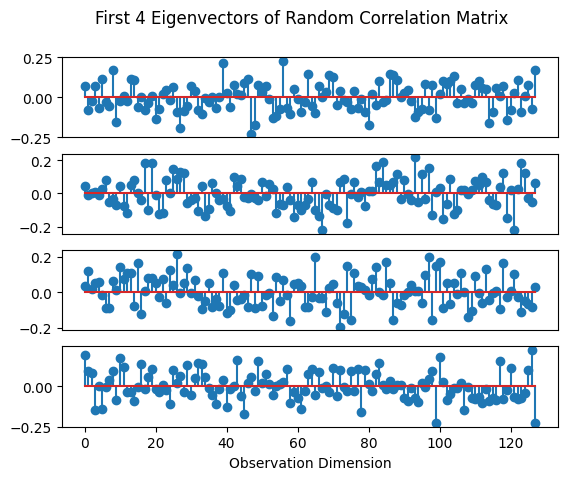

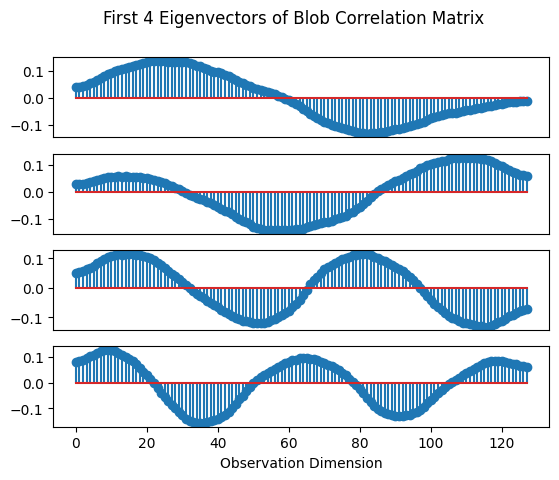

In [335]:
plt.figure()
for i in range(4):
    if i: plt.xticks([])
    plt.subplot(4, 1, i+1)
    plt.stem(U_rand[:,i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Random Correlation Matrix');

plt.figure()
for i in range(4):
    if i: plt.xticks([])
    plt.subplot(4, 1, i+1)
    plt.stem(U_blob[:,i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Blob Correlation Matrix');

Now lets plot all of the eigenvectors up to the cutoff at $2k=20$, that we observed in the eigenvalue spectrum of **section 2.1**. Rather than having 20 subplots, we plot each of the eigenvectors as a row of an image. We now you color, instead of a y-axis, to represent the numerical value of each coordinate in the eigenvector. Again, notice that the eigenvectors of the noisy data look like noise, where the non-noisy data has smooth pattern. We will explore this more deeply in the exercises.



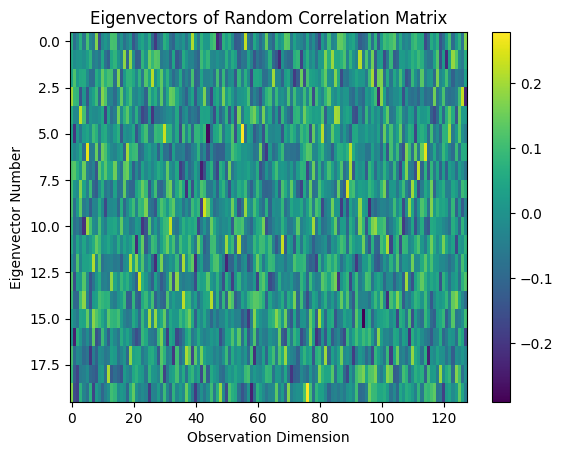

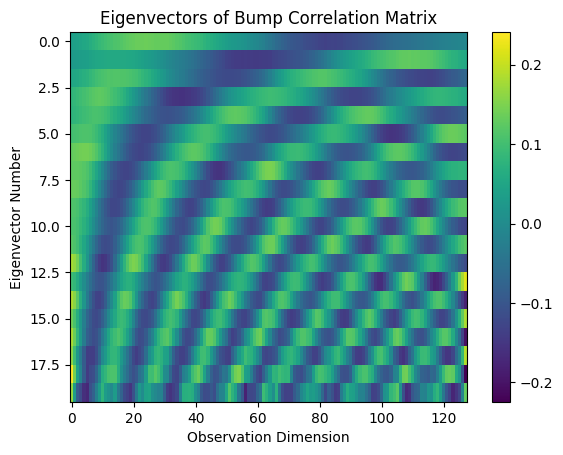

In [336]:
plt.figure(); plt.imshow(U_rand[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Random Correlation Matrix')
plt.colorbar()

plt.figure(); plt.imshow(U_blob[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Bump Correlation Matrix')
plt.colorbar();

# <font color="red"> Exercises

##  Noise Correlations <font color="red">10/10

Consider the correlation matrix shown in **section 2.2**:

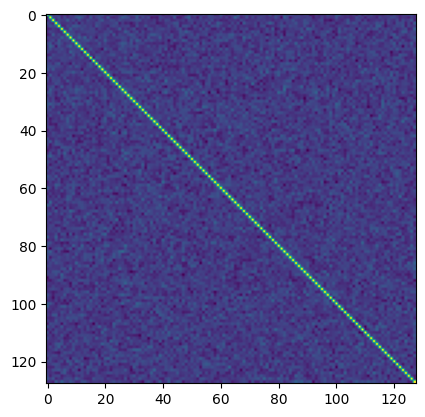

In [337]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

### Changing $N$ <font color="red">2/2

Try changing the value of $N$ in the cell that plots the correlation matrix. Try a few different orders of magnitude. How does the image change?

<font color="green"><b> Answer

<font color="green">Write code for creating plots with different values of $N$ below

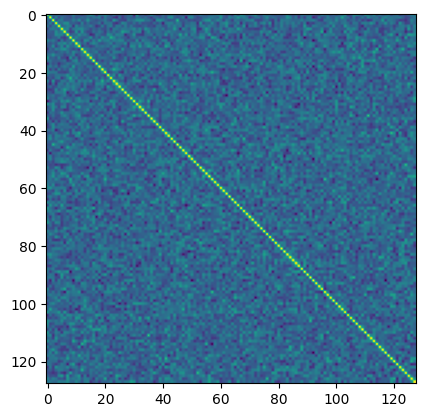

In [338]:
N, K = 50, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

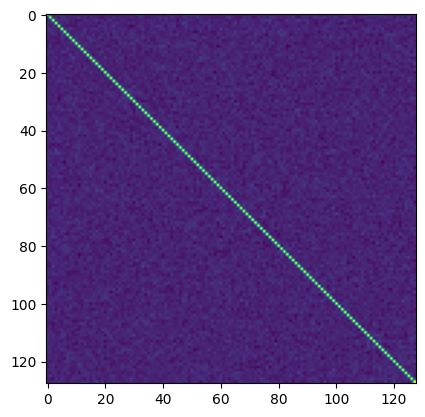

In [339]:
N, K = 1000, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
plt.imshow(C_rand);

<font color="green"> Write your explanation below.

If you increase N:
You should expect to see more accurate correlations because you're using more samples to compute them. This means the noise in the correlation matrix might reduce and the overall structure of the correlation matrix may become clearer.

If you decrease N:
You might see more noise in the correlation matrix because there's less data to analyze the correlations accurately. This could make the overall structure of the correlation matrix less clear or more noisy. 
Remember that a change in N won't affect the size of the correlation matrix as it's a K x K matrix. However, the quality and accuracy of the values in the Matrix can change with changing N. 

### Mean and SD <font color="red"> 5/5

Calculate, mathematically, the mean and standard deviation of the correlation coefficient between two independent Gaussian random variables with mean 0 and variance 1 over $N$ time points. Does your result agree with the intuition you gathered from the first exercise?

<font color="green"><b> Answer

<font color="green"> Write math calculation below

 1/√(N) to calculate SD of the sampling distribution of the correlation.

<font color="green"> Type explanation below.

The mean correlation coefficient is 0.
The standard deviation of the correlation coefficients is approximately 1/√(N) for large N.
This approximation holds for a big number N. As N increases, the standard deviation decreases, meaning that the sample correlation coefficient will be closer to the true correlation coefficient of 0.

### Data Manipulation <font color="red">1/1

Write some code that generates an array of all the off-diagonal elements of $C_\text{rand}$. (You can write straightforward Python loops for this, but alternately, in numpy, you can use boolean indexing on a 2D array to get a flat output, for example `X[np.eye(K, N, dtype=bool)]` gives you a 1D array of all the elements on the diagonal in the input data.)

<font color="green"><b> Answer

In [3]:
off_diag_indices = np.logical_not(np.eye(K, dtype=bool))
off_diag_elements = C_rand[off_diag_indices]
print(off_diag_elements)

[-0.12886541 -0.05766297  0.06266965 ...  0.01231552 -0.10484519
 -0.09218603]
16256


### Empirical Mean and SD <font color="red">2/2

Calculate the sample mean and standard deviation of the off-diagonal elements of $C$. How close are they to your predictions? 

<font color="green"><b> Answer

<font color="green"> Write code below

In [341]:
sample_mean = np.mean(off_diag_elements)
sample_std = np.std(off_diag_elements)
print(f'N={N}, sample_mean={sample_mean} and sample_std={sample_std}')

N=1000, sample_mean=-0.0007445395300785475 and sample_std=0.03134882852702101


<font color="green"> Write explanation below

In this case, with N=1000, the calculated sample mean is approximately -0.0007 and the sample standard deviation is approximately 0.0313. These values are quite similar to the predictions made earlier. Since the off-diagonal elements of C are expected to have a mean close to zero and a standard deviation close to 1/√N, the calculated values align with these expectations.

## Non-noise Correlations <font color="red">6/6

Consider the correlation matrix shown in **section 2.3**:

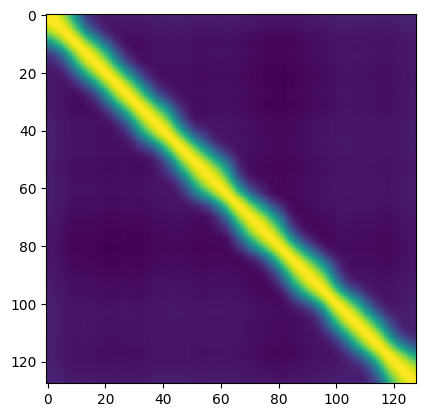

In [342]:
N, K = 250, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

### Changing $N$ <font color="red">2/2

This time, how does the correlation matrix change with different orders of magnitude for $N$?

<font color="green"><b> Answer

<font color="green">Write code for creating plots with different values of $N$ below

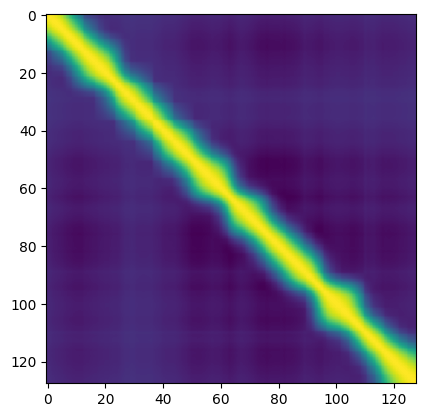

In [343]:
N, K = 50, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

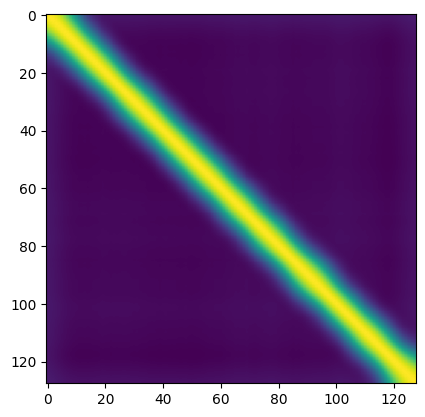

In [344]:
N, K = 1000, 128
k = 10
sigma = 5

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

With more data points, you have a better chance of accurately capturing the underlying structure of the data. The correlation matrix will have clearer blobs, and the values of the correlations between close points will be stronger than those of distant points. This results in more pronounced "blocks" of high correlation in the matrix, revealing a smoother structure.
Conversely, with less data, the structure will be less clear because each individual data point has a higher impact on the overall correlation structure. The correlation matrix will appear noisier and less structured.

### Small $N$ <font color="red">3/3

In particular, if you choose a very small value such as $N = 10$, you will see that some rows and columns of the correlation matrix display as white bars in the image, and if you inspect the matrix itself, the value in these locations is `nan`. This is short for “not a number”, and means that the code tried to evaluate an uninterpretable expression like $0 / 0$. Which part of the calculation is failing and why? (Hint: it is related to $k$.)

<font color="green"><b> Answer

<font color="green">Write code for creating the plot

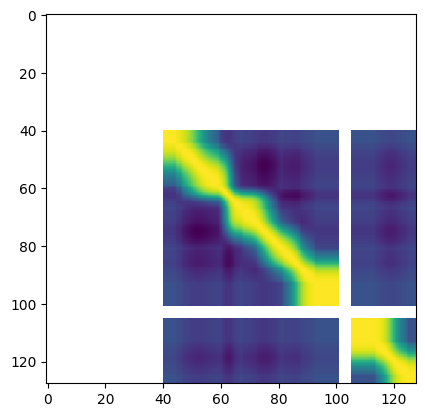

In [345]:
N, K = 10, 128  # n -> 10
k = 10
sigma = 5
np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

When N is too small, some points don't have any centers influencing them and thus will not perform anything, resulting in zero variation. When we attempt to calculate correlations, we need variation in both series. In this case, with zero variation, we end up dividing by zero in the correlation calculation, which is mathematically undefined. This leads the computer to return "Not a Number." These values are represented as white bars in the correlation matrix image.

### Changing Blob Size <font color="red">1/1

How does the correlation matrix change if you increase $k$ and $\sigma$ together? With $N$ back to its original value, try doubling $k$ and $\sigma$. Why does what you see occur?

<font color="green"><b> Answer

<font color="green">Write code for creating the plot

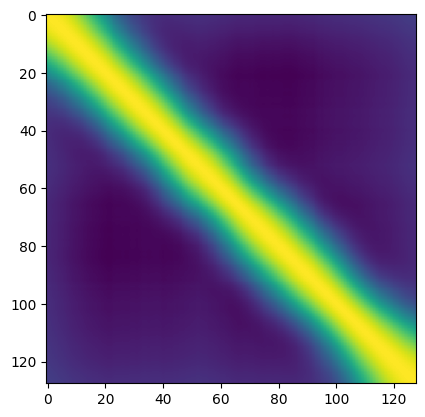

In [346]:
N, K = 250, 128  
k = 20  #k->20
sigma = 10  #sigma->10

np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])

mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
C_blob = np.corrcoef(X_blob)
plt.imshow(C_blob);

<font color="green"> Write your explanation below.

When you increase k and sigma together, the size of the "blob" or peak increases. This is due to the fact that k determines the range of points around each center that will receive influence, while sigma determines the scale or spread of the normal distribution used to generate these peaks or blobs. As a result, each observation is influenced by more points and the "blobs" are larger and smoother. In the correlation matrix, you'll see larger patches of high correlation, since more points are involved in each blob. This reflects a wider structure in the data compared to when k and sigma were smaller.

## Eigenvalue Spectrum <font color="red">5/5

Consider the eigenvalues and eigenvectors from **section 2.1**:

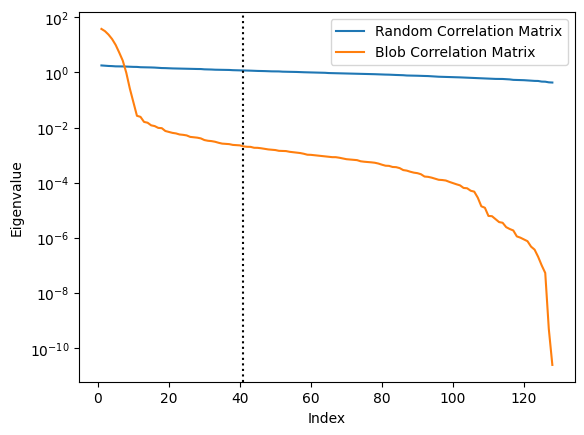

In [347]:
W_rand, U_rand = eigenvalues_eigenvectors(C_rand)  # noise correlation matrix from above
W_blob, U_blob = eigenvalues_eigenvectors(C_blob)  # non-noise correlation matrix from above 

index = 1 + np.arange(K)
plt.semilogy(index, W_rand, label='Random Correlation Matrix')
plt.plot(index, W_blob, label='Blob Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.axvline(2*k+1, ls=':', c='k')
plt.legend();

### Calculate Eigenvalues <font color="red">3/3

Calculate the sum of the eigenvalues for both `C_rand` and `C_blob`. What do you immediately notice about those values? Why does this happen? (Hint: consider the <a href=https://en.wikipedia.org/wiki/Trace_(linear_algebra)>trace</a> of the correlation matrix.)

<font color="green"><b> Answer

<font color="green"> Write your code below.

In [348]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)
N, K = 250, 128
k = 10
sigma = 5
# Create raw Gaussian blobs of the given sigma. The easiest
# way to do this in numpy/scipy is to use the normal distribution
# from scipy.stats. The "points" are the points on the retina, and
# the "centers" are the centers of the different observations in
# retina space.
np.random.seed(0)
points = np.arange(K)
centers = np.random.rand(N) * K
X_blob = scipy.stats.norm(
    scale=sigma, loc=centers
).pdf(points[:,np.newaxis])
# Mask the blobs off to k entries.
mask = np.abs(np.subtract.outer(points, centers)) < k
X_blob *= mask
# Plot the correlation.
C_blob = np.corrcoef(X_blob)

sum_W_rand = np.sum(W_rand)
sum_W_blob = np.sum(W_blob)
print(f'Sum of eigenvalues for C_rand: {sum_W_rand}')
print(f'Sum of eigenvalues for C_blob: {sum_W_blob}')

Sum of eigenvalues for C_rand: 128.0
Sum of eigenvalues for C_blob: 127.99999999999996


<font color="green"> Write your explanation below.

The sum of the eigenvalues of a matrix is equal to the trace of the matrix. The trace of a matrix is the sum of its diagonal elements. For this correlation matrix, the diagonal elements are always 1 (since the correlation of a variable with itself is 1), so the sum of the eigenvalues (the trace of the matrix) should be equal to the number of variables (or dimensions), which in this case is K=128.

### Eigenvalue Analysis <font color="red">2/2

3. The magnitude of an eigenvalue is, loosely speaking, its importance to the transformation represented by the matrix, so the more of the sum is concentrated in the first few eigenvalues, the lower the dimensionality of the representation.
    1. Compute the sum of the first $2k$ eigenvalues for both `C_rand` and `C_blob`.
    2. Between the 2, compare how many eigenvalues it takes to reach $90\%$ of the full sum for both correlation matrices.

<font color="green"><b> Answer

<font color="green"> Write your code below. It should output answers to the questions above.

In [354]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)

sum_W_rand_2k = np.sum(W_rand[:2*k])
sum_W_blob_2k = np.sum(W_blob[:2*k])
print(f'Sum of first 2k eigenvalues for C_rand: {sum_W_rand_2k}')
print(f'Sum of first 2k eigenvalues for C_blob: {sum_W_blob_2k}')

cumulative_W_rand = np.cumsum(W_rand)
cumulative_W_blob = np.cumsum(W_blob)
index_rand_90 = np.where(cumulative_W_rand >= 0.9 * sum_W_rand)[0][0]
index_blob_90 = np.where(cumulative_W_blob >= 0.9 * sum_W_blob)[0][0]
print(f'It takes {index_rand_90+1} eigenvalues to reach 90% of the full sum for C_rand')
print(f'It takes {index_blob_90+1} eigenvalues to reach 90% of the full sum for C_blob')

Sum of first 2k eigenvalues for C_rand: 31.610301370186125
Sum of first 2k eigenvalues for C_blob: 127.87349766100391
It takes 105 eigenvalues to reach 90% of the full sum for C_rand
It takes 5 eigenvalues to reach 90% of the full sum for C_blob


## Eigen Vector Basis <font color="red">8/8

Consider the diagrams in **Section 2.2**:

### Low Rank Approximations <font color="red">3/3

Clearly the first few eigenvectors of `C_blob` are significantly more meaningful in some sense than those of `C_rand`. Let's try to explicitly quantify this! Complete the function `reconstruct(W, U, rank)` below to generate a low-rank approximation using the first `rank` eigenvalues and eigenvectors from the given `W` and `U`, so that the below cell will generate a plot of the relative reconstruction error as a function of the rank of the reconstruction.

<font color="green"><b> Answer

<font color="green"> Write your code for the function `reconstruct` below

In [350]:
def reconstruct(W, U, rank):
    W_diag = np.diag(W[:rank])
    A_reconstructed = np.einsum('ij,jj,jk->ik', U[:, :rank], W_diag, U[:, :rank].T)
    return A_reconstructed

Execute the cell below to see a plot. What trend do you see as the rank is varied? Why?

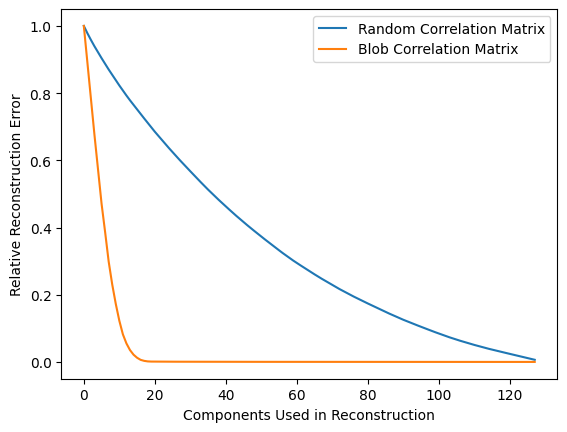

In [351]:
N, K = 250, 128
np.random.seed(0)
X_rand = np.random.randn(K, N)
C_rand = np.corrcoef(X_rand)

def reconstruction_errors(A, ranks):
    norm = np.linalg.norm(A)
    W, U = eigenvalues_eigenvectors(A)
    return np.array([
            np.linalg.norm( reconstruct(W, U, rank) - A) / norm
            for rank in ranks])

errs_rand = reconstruction_errors(C_rand, range(128))
errs_blob = reconstruction_errors(C_blob, range(128))

plt.figure()
plt.plot(errs_rand, label='Random Correlation Matrix')
plt.plot(errs_blob, label='Blob Correlation Matrix')
plt.xlabel('Components Used in Reconstruction')
plt.ylabel('Relative Reconstruction Error')
plt.legend();

<font color="green"> Describe the resulting plot:

Once you execute the code above, you will see a plot of the relative reconstruction error for both the Random Correlation Matrix and the Blob Correlation Matrix. As the number of components or rank used in the reconstruction increases, the error will decrease. The Blob Correlation Matrix, having a structured pattern, would show a steeper decrease in the reconstruction error compared to the Random Correlation Matrix. This is because a correlated dataset can be approximated more accurately using fewer components.

### Toeplitz Matrices <font color="red">3/3

Going back to the form of the eigenvectors themselves, they actually look a lot like the sinusoids which would be the components of a Fourier series. That's actually coming from the matrix being almost <a href=https://en.wikipedia.org/wiki/Toeplitz_matrix>Toeplitz</a>. It's a general property of Toeplitz matrices that their eigenvectors are Fourier components, because matrices with this form represent linear, time-invariant transformations. Let's see how it changes things to fulfill this property exactly instead of approximately. Create a new matrix $C_\text{Toeplitz}$ by setting each of the diagonals to the mean of the corresponding diagonal in $C_\text{blob}$.


<font color="green"><b> Answer

<font color="green"> Write your code to contstruct the Toeplitz matrix

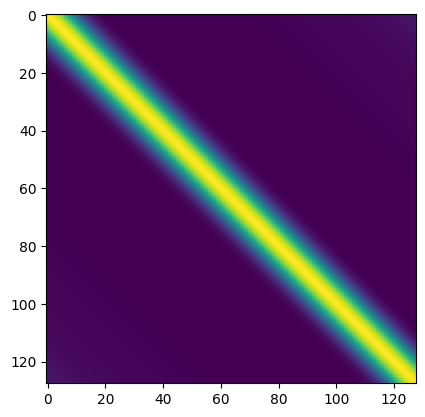

In [352]:
def create_toeplitz(matrix):
    K,_ = matrix.shape 
    toeplitz_matrix = np.zeros_like(matrix) 
    for i in range(-K + 1, K): 
        mean_val = np.mean(np.diagonal(matrix, offset=i))
        toeplitz_matrix += np.eye(K, K, k=i) * mean_val
        toeplitz_matrix += np.eye(K, K, k=-i) * mean_val
    return toeplitz_matrix

C_toeplitz = create_toeplitz(C_blob)
plt.imshow(C_toeplitz);

### Toeplitz Eigenvectors <font color="red">2/2

Compute the eigenvectors of $C_\text{Toeplitz}$ and plot them both ways, as shown in **section 2.2**. How does this plot compare to the eigenvectors of $C_\text{blob}$?

<font color="green"><b> Answer

<font color="green"> Write your code to compute the eigenvectors

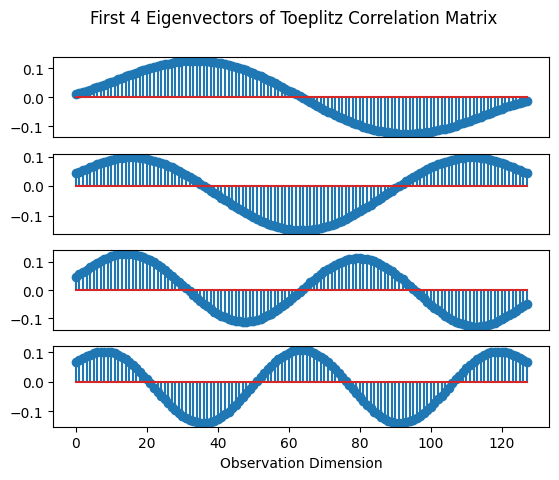

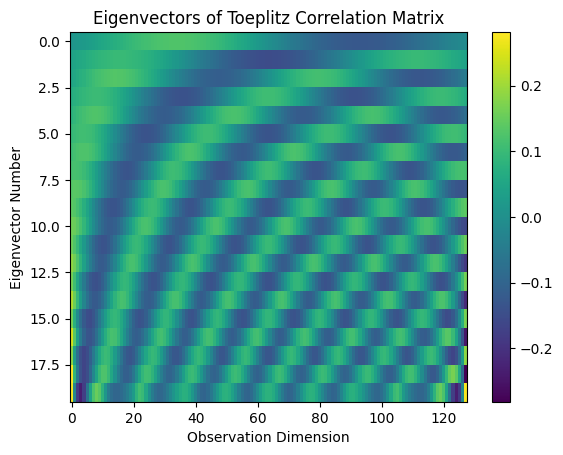

In [353]:
W_toeplitz, U_toeplitz = eigenvalues_eigenvectors(C_toeplitz)

plt.figure()
for i in range(4):
    if i:
        plt.xticks([])
    plt.subplot(4, 1, i + 1)
    plt.stem(U_toeplitz[:, i])
plt.xlabel('Observation Dimension')
plt.suptitle('First 4 Eigenvectors of Toeplitz Correlation Matrix')

plt.figure(); plt.imshow(U_toeplitz[:,:2*k].T, interpolation='none')
plt.gca().set_aspect('auto')
plt.ylabel('Eigenvector Number')
plt.xlabel('Observation Dimension')
plt.title('Eigenvectors of Toeplitz Correlation Matrix')
plt.colorbar()

<font color="green">Compare plots

The Eigenvectors of the Toeplitz Correlation Matrix look way smoother than those of C_blob. The correlation matrix also forms a clearer pattern when compared to C_blob. 